In [1]:
# CLone my repo that contains the shell file
!git clone https://gist.github.com/f7b7c7758a46da49f84bc68b47997d69.git
!cd f7b7c7758a46da49f84bc68b47997d69/
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
!dpkg --install cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda
# Check the version of CUDA on the system
!cat /usr/local/cuda/version.txt
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision
  
import torch

print("PyTorch version: ")
print(torch.__version__)
print("CUDA Version: ")
print(torch.version.cuda)
print("cuDNN version is: ")
print(torch.backends.cudnn.version())

fatal: destination path 'f7b7c7758a46da49f84bc68b47997d69' already exists and is not an empty directory.
--2019-01-26 09:24:00--  https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.182.215
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.182.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64.deb?sAFF7ZT6Cu7-Wn02dwwzKyO57lGFfhu0-Gx75_4dZIZEBDT6Cyrzp6N73usPHWVCA249--h0YgJ8ZwwZhFLkHytFl2aXBJPv7U5o9ZRsu_8pDYhV5n-A8t2CFVSiN0AE8z4L7oGJ7OsM0-_bPiyonzWRtBw4z7lSwse65WN8tr5254JCl80TO0fFvmeoUZmXPTHd-cFz_6x3DVO7tkFlkw [following]
--2019-01-26 09:24:01--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64.deb?sAFF

In [0]:
import torch
import torch.nn.functional as F

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [0]:
class VAELoss(torch.nn.Module):
  def __init__(self):
    super(VAELoss, self).__init__()
  
  def forward_kl(self, q_mean, q_cov_log):
    _cov_log_diag = q_cov_log
    _mean_vector = q_mean
    
    return (q_mean.shape[1] + _cov_log_diag - q_mean ** 2 - torch.exp(_cov_log_diag)).mean() * (-0.5)
    
  def forward(self, input, q_mean, q_cov, target):
    return (self.forward_kl(q_mean, q_cov) + F.mse_loss(input, target)) * q_mean.shape[0] / 2
    

In [0]:
class CVAELeNet(torch.nn.Module):
  def __init_encoder(self):
    self.random_normal = torch.distributions.Normal(0, 1)
    
    # input channel = 1, output channel = 6, kernel_size = 5
    # input size = (32, 32), output size = (28, 28)
    self.e_conv1 = torch.nn.Conv2d(1, 6, 5)
    # input channel = 6, output channel = 16, kernel_size = 5
    # input size = (14, 14), output size = (10, 10)
    self.e_conv2 = torch.nn.Conv2d(6, 16, 5)
    # input dim = 16*5*5, output dim = 120
    self.e_fc1 = torch.nn.Linear(256 + 10, 120)
    self.e_fc2 = torch.nn.Linear(120, 84)
    self.fc_mean = torch.nn.Linear(84, 5)
    self.fc_cov = torch.nn.Linear(84, 5)
    
  
  def __init_decoder(self):
    self.d_fc1 = torch.nn.Linear(5+10, 84)
    self.d_fc2 = torch.nn.Linear(84, 120)
    self.d_fc3 = torch.nn.Linear(120, 256)
    self.d_dconv1 = torch.nn.ConvTranspose2d(16, 6, 9)
    self.d_dconv2 = torch.nn.ConvTranspose2d(6, 1, 17)
  
  def __sample(self, mean_vec, cov_vec):
    normal_values = self.random_normal.sample(torch.Size(mean_vec.shape)).cuda()
    return mean_vec + normal_values * torch.exp(0.5 * cov_vec)
  
  def forward_encoder(self, x, c):
    x = F.max_pool2d(F.relu(self.e_conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.e_conv2(x)), 2)
    x = x.view(x.size()[0], -1)
    x = F.dropout(x)
    x = torch.cat([x, c], 1)
    x = F.relu(self.e_fc1(x))
    x = F.dropout(x)
    x = F.relu(self.e_fc2(x))
    
    _mean = self.fc_mean(x)
    _cov = self.fc_cov(x)
    
    return _mean, _cov
  
  def forward_decoder(self, x, c):
    x = torch.cat([x, c], 1)
    x = F.relu(self.d_fc1(x))
    x = F.dropout(x)
    x = F.relu(self.d_fc2(x))
    x = F.dropout(x)
    x = F.relu(self.d_fc3(x))
    x = x.view(x.size()[0], 16, 4, 4)
    x = F.relu(self.d_dconv1(x))
    x = F.relu(self.d_dconv2(x))
    
    return x
  
  def __init__(self):
    super(CVAELeNet, self).__init__()
    
    
    self.e_conv1 = None
    self.e_conv2 = None
    self.e_fc1 = None
    self.e_fc2 = None
    self.e_fc_mean = None
    self.e_fc_cov = None
    
    self.d_fc1 = None
    self.d_fc2 = None
    self.d_fc3 = None
    self.d_dconv1 = None
    
    
    self.__init_encoder()
    self.__init_decoder()
    
  def forward(self, x, c):
    _mean, _cov = self.forward_encoder(x, c)
    _latent_var = self.__sample(_mean, _cov)
    return _mean, _cov, self.forward_decoder(_latent_var, c)
   

In [0]:
net = CVAELeNet().cuda()

In [0]:
criterion = VAELoss().cuda()
optimizer = torch.optim.RMSprop(net.parameters(), lr = .001)

In [9]:
X = mnist_trainset.train_data.reshape(-1, 1, 28, 28).type(torch.FloatTensor) / 255.
y = mnist_trainset.train_labels
y_onehot = torch.zeros((y.shape[0], 10))
y_onehot.scatter_(1, y.reshape(-1, 1), 1)

print(X.shape, y.shape, y_onehot.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([60000, 10])


In [0]:
X = X.cuda()
y = y.cuda()
y_onehot = y_onehot.cuda()

In [63]:
  net.train()
  for epoch in range(100):
    for batch in range(X.shape[0] // 512):
      optimizer.zero_grad()
      
      X_sub = torch.autograd.Variable(X[batch*512:(batch+1)*512], requires_grad = False).cuda()
      #y_sub = torch.autograd.Variable(y[batch*128:(batch+1)*128], requires_grad = False).cuda()
      y_sub = torch.autograd.Variable(y_onehot[batch*512:(batch+1)*512], requires_grad = False).cuda()

      _mean, _cov, output = net(X_sub, y_sub)
      loss = criterion(X_sub, _mean, _cov, output)#, y_sub)
      loss.backward()
      optimizer.step()
    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch,loss.data))

epoch 0, loss 1926319.25
epoch 10, loss 1856938.625
epoch 20, loss 1940076.25
epoch 30, loss 1954057.75
epoch 40, loss 1898042.625
epoch 50, loss 1886348.375
epoch 60, loss 1881536.5
epoch 70, loss 1881080.375
epoch 80, loss 2209637.0
epoch 90, loss 1907662.875


In [0]:
ix_digit = 5

digit_encoded = np.zeros(10)
digit_encoded[ix_digit] = 1
digit_encoded = digit_encoded.reshape(1, -1).astype(np.float32)

decoded_images = list()
for i in range(100):
  digit_encoded = np.zeros(10)
  digit_encoded[i // 10] = 1
  digit_encoded = digit_encoded.reshape(1, -1).astype(np.float32)

  
  noizy_shit = np.random.normal(0, 1, 5).reshape(1, -1).astype(np.float32)
  decoded_images.append(net.forward_decoder(
      torch.from_numpy(noizy_shit).cuda(),
      torch.from_numpy(digit_encoded).cuda()
      
      
  ).detach().cpu().numpy())

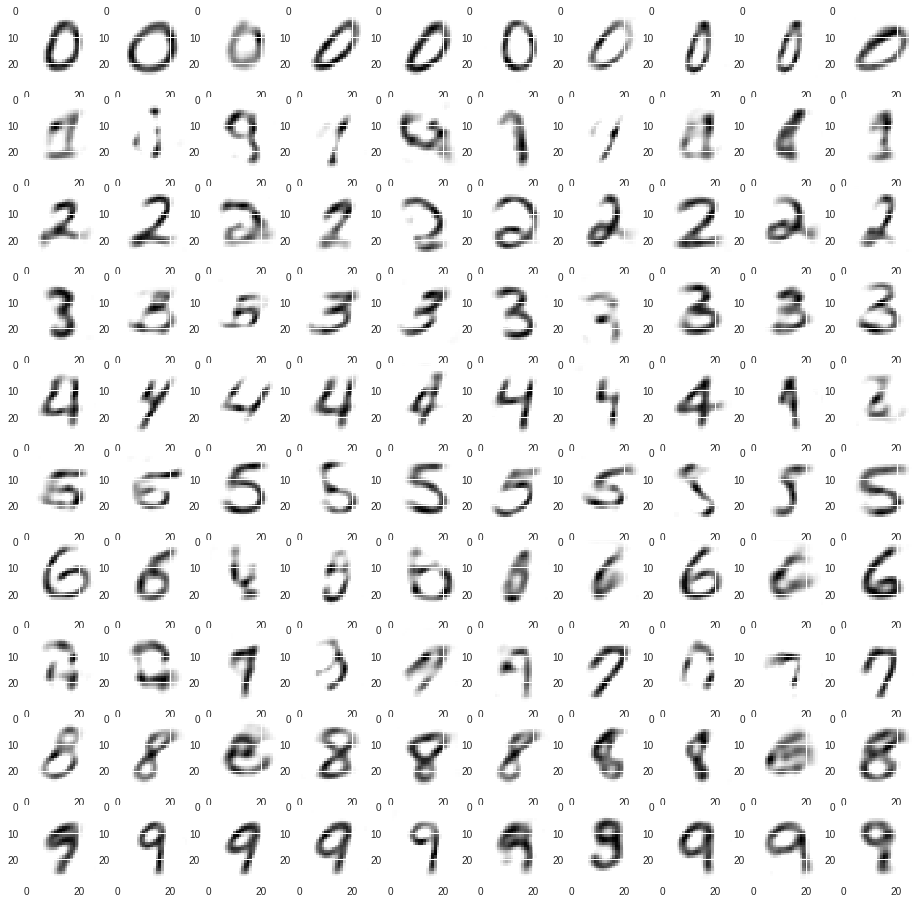

In [80]:
fig=plt.figure(figsize=(16, 16))
for i in range(100):
    fig.add_subplot(10, 10, i+1)
    plt.imshow((decoded_images[i][0][0] * 255).astype(int))
plt.show()